<h1 style="color:rgb(0,120,170)">Neural Networks -- Vanishing Gradient</h1>
<h2 style="color:rgb(0,120,170)">OEAW Machine Learning Summer School 2019</h2>

This notebook is a visualization of the famous Vanishing Gradient problem. It should foster your understanding of what happens to the weights in the different layers. If you want to further stretch the topic you can try to implement different activation functions.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Hyperparameters
args = SimpleNamespace(batch_size=64, test_batch_size=1000, epochs=1,
                       lr=0.01, momentum=0.5, seed=1, log_interval=100)
torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [3]:
# Data loader (downloads data automatically the first time)
# 0.1307 and 0.3081 are the mean and the std computed on the training set
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join('.','..','data'), train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join('.','..','data'), train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

torch.Size([60000])
torch.Size([60000, 28, 28])
Input dimension is 784.


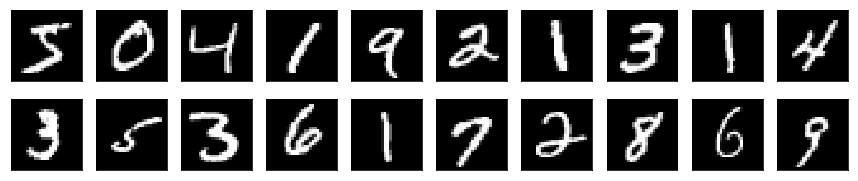

In [4]:
print(train_loader.dataset.targets.shape)
print(train_loader.dataset.data.shape)
input_dim = train_loader.dataset.data.shape[1]*train_loader.dataset.data.shape[2]
print("Input dimension is {}.".format(input_dim))
output_dim = 10

# Plot example images
fig=plt.figure(figsize=(15,3))
for image in range(20):
    show_img = train_loader.dataset.data[image].numpy().reshape(28, 28)
    fig.add_subplot(2,10,image+1)
    plt.xticks([]),plt.yticks([])
    plt.imshow(show_img, cmap='gray')
plt.show()

Two network moduls are defined. Both have 3 hidden layers with the same size of neurons. The only difference is the activation functions. The sigmoid activation function will cause the gradients to vanish.

In [5]:
class ANN_sigmoid(nn.Module):
    def __init__(self, D_in, D_out):
        super(ANN_sigmoid, self).__init__()
        self.linear1 = nn.Linear(D_in, 512)
        self.linear2 = nn.Linear(512, 1024)
        self.linear3 = nn.Linear(1024, 512)
        self.linear4 = nn.Linear(512, D_out)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.sigmoid(x)
        x = self.linear2(x)
        x = torch.sigmoid(x)
        x = self.linear3(x)
        x = torch.sigmoid(x)
        x = self.linear4(x)
        return F.log_softmax(x, dim=1)
    
    
class ANN_relu(nn.Module):
    def __init__(self, D_in, D_out):
        super(ANN_relu, self).__init__()
        self.linear1 = nn.Linear(D_in, 512)
        self.linear2 = nn.Linear(512, 1024)
        self.linear3 = nn.Linear(1024, 512)
        self.linear4 = nn.Linear(512, D_out)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        x = self.linear4(x)
        return F.log_softmax(x, dim=1)

In [6]:
# This function trains the model for one epoch
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    grads1_list = []
    grads2_list = []
    grads3_list = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data = Variable(data.view(-1, input_dim))
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        
        # This part of the code gets the weights in the different layers
        grads3 = abs(model.linear3.weight.grad)
        grads2 = abs(model.linear2.weight.grad)
        grads1 = abs(model.linear1.weight.grad)
        grads3_list.append(torch.sum(grads3).item())
        grads2_list.append(torch.sum(grads2).item())
        grads1_list.append(torch.sum(grads1).item())
        
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    return grads1_list, grads2_list, grads3_list

In [7]:
# This function evaluates the model on the test data
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = Variable(data.view(-1, input_dim))
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))    

<<<<<<< SIGMOID <<<<<<<
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.344906
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.298969
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.309132
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.311138
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.301284
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.312292
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.288452
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.299210
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.327736
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.307887


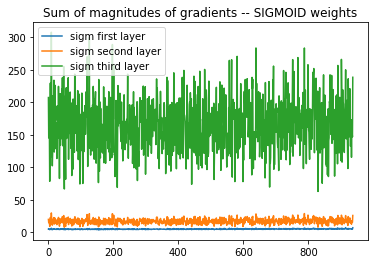


Test set: Average loss: 2.2990, Accuracy: 1032/10000 (10.32%)

<<<<<<< RELU <<<<<<<
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304875
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.834425
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.542324
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.413239
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.301887
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.376627
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.221851
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.217755
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.432649
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.206814


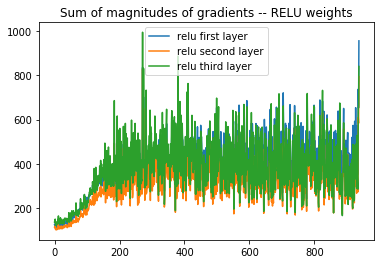


Test set: Average loss: 0.2808, Accuracy: 9164/10000 (91.64%)



In [8]:
# Main
print("<<<<<<< SIGMOID <<<<<<<")
model = ANN_sigmoid(input_dim, output_dim).to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, 
                      momentum=args.momentum)

for epoch in range(1, args.epochs + 1):
    grads1_list, grads2_list, grads3_list = train(args, model, device, train_loader, optimizer, epoch)
    plt.plot(np.array(grads1_list))
    plt.plot(np.array(grads2_list))
    plt.plot(np.array(grads3_list))
    plt.title('Sum of magnitudes of gradients -- SIGMOID weights')
    plt.legend(("sigm first layer", "sigm second layer", "sigm third layer"))
    plt.show()
  
    test(args, model, device, test_loader)

del model    
print("<<<<<<< RELU <<<<<<<")
model = ANN_relu(input_dim, output_dim).to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, 
                      momentum=args.momentum)

for epoch in range(1, args.epochs + 1):
    grads1_list, grads2_list, grads3_list = train(args, model, device, train_loader, optimizer, epoch)
    plt.plot(np.array(grads1_list))
    plt.plot(np.array(grads2_list))
    plt.plot(np.array(grads3_list))
    plt.title('Sum of magnitudes of gradients -- RELU weights')
    plt.legend(("relu first layer", "relu second layer", "relu third layer"))
    plt.show()
    
    test(args, model, device, test_loader)